# Plot Concentration Bound
---

## Import Packages

In [27]:
# Directory Management
import os
os.chdir(os.getcwd())

# Compute
import math
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# Data Structures
import numpy as np
import pandas as pd

# General
import math
from decimal import Decimal

# Plot
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
sns.set_theme(style="darkgrid")

## Global Hyperparameters

In [2]:
N = 10**2
k = 10**5

# Confidence
delta = .95

# Lipschitz Functions
L = 1

# X Complexity
diam = 1
Representation_Space_Dim_Max = 1000
print(np.log(Representation_Space_Dim_Max))

# Worst-Case Distortion?  If not, specify
distortion_given = 1#False 

# Y Complexity
Y_is_bin_class = True

6.907755278982137


## Helper Function(s)

#### Formatting Function

In [24]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

### Internal Parameters

In [3]:
# Generate Array of Representation Dimensions
F_in = np.round(range(1,Representation_Space_Dim_Max))
# Get Small Values
F_in__1 = np.round(range(int(8*math.log(k)),int(20*math.log(k))))
# Get Large Values
F_in__2 = np.round(range(int(8*math.log(k)),int(Representation_Space_Dim_Max)))
F_in__2 = np.random.choice(F_in__2,100, replace=False)
# Assemble Values
F_in = np.append(F_in,F_in__1)
F_in = np.append(F_in,F_in__2)
# Keep Unique
F_in = np.sort(np.unique(F_in))

# The Risk Bound Computers

## Ours

This function computes the risk-bound in our main Theorem.

In [4]:
def get_risk_bound__scalar(N,k,F,distortion_known=distortion_given):
    # Round N, k, and F down (failsafe)
#     N = int(max(1,N))
#     k = max(1,round(k))
#     F = max(1,round(F))
    #-----------------------------------------#
    ## Case-By-Case Definition of Quantities ## 
    #-----------------------------------------#
    ## -------------------- ##
    ## Low Dimensional Case ##
    ## -------------------- ##
    if F<=2:
        #Test if Distortion is Known, if not..put worst-case
        if distortion_known == False: 
            # Set worst-Case distortion for embedding into at-most two-dimensional Euclidean space
            dist = 12*k
        else:
            # Set Custom Distortion
            dist = distortion_known
            
        # Get Remaining Constants for Concentration Theorem
        if F == 1:
            # rate
            rate = 1/np.sqrt(N)
            # C_F
            C_F = 1/(np.sqrt(8)-2)
        if F == 2:
            # rate
            rate = (32+math.log2(N))/np.sqrt(N)
            # C_F
            C_F = np.sqrt(2)/4
            
    ## ------------------------ ##
    ## Non-Low Dimensional Case ##
    ## ------------------------ ##         
    if F > 2:
        # rate
        rate = 1/(N**(1/F))
        # C_F
        C_F__1 = 2
        C_F__2 = ((F/2)-1)/(2*(1-2**(1-(F/2))))
        C_F__2 = C_F__2**(2/F)
        C_F__3 = (1+1/(2*((F/2)-1)))
        C_F__4 = np.sqrt(F)
        C_F = C_F__1*C_F__2*C_F__3*C_F__4

        
        #Test if Distortion is Known, if not..put worst-case
        if distortion_known == False: 
            # Set worst-Case distortion for embedding into F-dimensional Euclidean space  
            
            # The following is used in all cases where F>2
            ε_mk = (2**(3/2))*(math.log(k)**.5)/F
            tilde_ε_mk_1 = (np.abs(1+ε_mk))**.5
            tilde_ε_mk_2 = (np.abs(1-ε_mk))**.5
            tilde_ε_mk = tilde_ε_mk_1/tilde_ε_mk_2
            
            ## ------------------------- ##
            ## Moderate-Dimensional Case ##
            ## ------------------------- ##    
            
            if F <= 8*np.round(math.log(k),0):
                dist__1 = 720*tilde_ε_mk
                dist__2 = (math.log(k)/k)**.5
                dist__3 = k**(2/F)
                dist__4 = (k/F)**.5
                dist__5 = math.floor(2*math.log2(k)+1)
                
                dist = tilde_ε_mk*dist__1*dist__2*dist__3*dist__4*dist__5
                
            else:
                dist__1 = 48*math.floor(2*math.log2(k)+1) # This is used in both of the following cases
                ## --------------------- ##
                ## High-Dimensional Case ##
                ## --------------------- ##    
                if F < 2**k:
                    dist = dist__1*tilde_ε_mk
                    
                ## -------------------------- ##
                ## Very High-Dimensional Case ##
                ## -------------------------- ##    
                if F >= 2**k:
                    dist = dist__1
                        
        
        else:
            # Set Custom Distortion
            dist = distortion_known

    #-----------------#
    ## Compute Bound ## 
    #-----------------#
    bound__1 = L*diam
    bound__2 = C_F*(2*dist-1)*rate
    bound__3 = (math.log(2/delta)**.5)**dist
    bound__4 = 1/np.sqrt(N)

    bound = bound__1*bound__2*(bound__3+bound__4)

    return bound

get_risk_bound = np.vectorize(get_risk_bound__scalar)

### Search for Best Bound for a Given N

Use this code to estimate
$$
\inf_{m\in \mathbb{N}_+}\,
            L
            \operatorname{diam}(\mathcal{X}\times\mathcal{Y})
            \,
            \big(
            C_m
            \,
            (2\tau(\varphi)-1)\,
                \mathrm{rate}_m(N)
            \,
            +
            %%% Our magic value of epsilon
            \frac{
                    \ln(2/\delta)^{1/2}\tau(\varphi)
                }{
                    N^{1/2}
                }
        \big)
$$
This next code segment also returns the best representation dimension for the given $N$ and $k$.

In [5]:
def find_best(k=k,N=N,bar_N=N,verbose=False):

    # Initialize Best Representation Dimension
    BEST_F = F_in[0]
    min_bound = get_risk_bound__scalar(N=N,k=k,F=F_in[0],distortion_known=distortion_given)
    
    # Search for Best Bound
    for F_loop in F_in:
        bound = get_risk_bound__scalar(N=N,k=k,F=F_loop,distortion_known=distortion_given)
        if verbose == True:
            print(bound)
        if bound < min_bound:
            min_bound = bound
            BEST_F = F_loop
    return BEST_F,min_bound

# print(F_in)
BEST_F = find_best(verbose=False)[0]
Tightest_Bound = find_best()[1]
print(BEST_F)
print(Tightest_Bound)

1
0.11622140454851408


## Benchmark: Trivial VC/Occam Bound (Binary Classification)
From the The (Quantitative) Fundamental Theorem of Statistical Learning ([Theorem 6.8 in "Understanding Machine Learning" (with extra details in Section 28.1)](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=kezPqwoAAAAJ&citation_for_view=kezPqwoAAAAJ:XiVPGOgt02cC)
$$
\begin{aligned}
    \mathcal{R}(f) - \hat{\mathcal{R}}^{\mathcal{D}}(f)
\le &
    n^{-1/2}
    (
        128 \operatorname{VC-dim}\log(n+1) + \log(8/\delta)
    )^{1/2}
\\ 
\le & 
    n^{-1/2}
    (
        128 \#\mathcal{X}\log(n+1) + \log(8/\delta)
    )^{1/2}
\end{aligned}
$$
where we use the fact that $\operatorname{VC-dim}(2^{\mathcal{X}})\le \log_2(\#2^{\mathcal{X}})=\#\mathcal{X}$.

In [6]:
def trivial_VCBound(N_in=N,k_in=k,delta = delta):
    a = 1/np.sqrt(N_in)
    b = 128 * k_in *np.log(N_in+1)
    c = np.log(8/delta)
    d = np.sqrt(b*c)
    return a*d

## Hoeffding Bound


From [Corollary 4.6 of "Understanding Machine Learning"](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=kezPqwoAAAAJ&citation_for_view=kezPqwoAAAAJ:XiVPGOgt02cC) we have the following Heofding-type bound
$$
\begin{aligned}
    (2n)^{-1/2}
    \log\big(
    2 \times 2^k/\delta
    \big)^{1/2}
    = 
    (2n)^{-1/2}
     \big(
     \log(2/\delta) + k\log(2)
     \big)^{1/2}
\end{aligned}
$$

In [7]:
# Heoffding-Type Bound
def Hoeffding_Bound(N_in=N,k_in=k,delta = delta):
    a = 1/np.sqrt(2*N_in)
    b = np.log(2/delta)
    c = k_in*np.log(2)
    d = np.sqrt(b+c)
    return a*d

## Generate Plot

### Fixed k 

In [8]:
# Set External Values of k and F
k_global = 10**2

N_min = 10
N_max = 10**3
N_tests = 10


# Generate Sequence of Number of Samples
N_sequence = np.linspace(N_min,N_max,N_tests)

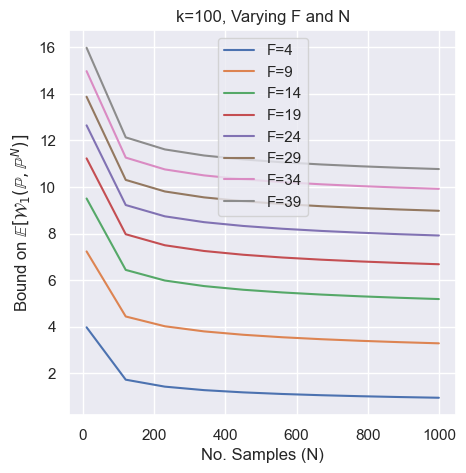

In [9]:
plt.figure(figsize=(5,5))

plt.title('k='+str(k_global)+', Varying F and N')
plt.xlabel('No. Samples (N)')
plt.ylabel('Bound on $\mathbb{E}[\mathcal{W}_1(\mathbb{P},\mathbb{P}^N)]$')

for i in range(4,40,5):
    # Set Value of F
    F_global = int(np.round(i,0))
    
    # Function of N only
    def get_risk_bound__NVar_scalar(N):
        return get_risk_bound__scalar(k=k_global,F=F_global,N=N)
    
    get_risk_bound__NVar = np.vectorize(get_risk_bound__NVar_scalar)
    
    # Compute Risk Bound
    Risk_Bounds = get_risk_bound__NVar_scalar(N_sequence)
    
    # Plot
    plt.plot(N_sequence, Risk_Bounds,label = 'F='+str(F_global).format(i=i))
    
plt.legend(loc='best')

plt.savefig('NF_kis'+str(k_global)+'.pdf')
plt.show()

### Fixed N

In [10]:
# Set External Values of k and F
N_global = 10**5

F_min = 4
F_max = 10**5
F_tests = 50


# Generate Sequence of Number of Samples
F_sequence = np.linspace(F_min,F_max,F_tests)

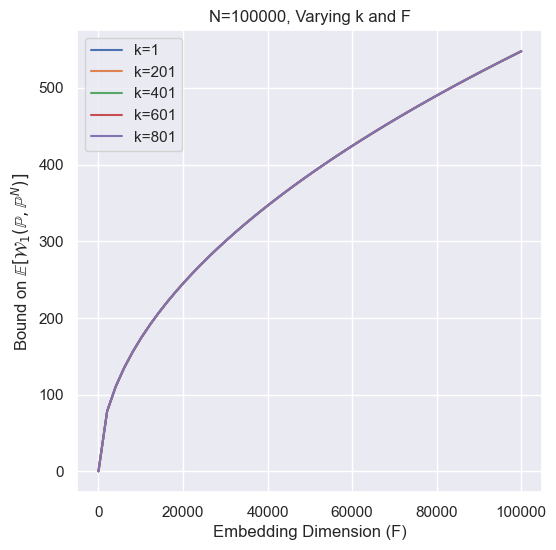

In [11]:
plt.figure(figsize=(6,6))

plt.title('N='+str(N_global)+', Varying k and F')
plt.xlabel('Embedding Dimension (F)')
plt.ylabel('Bound on $\mathbb{E}[\mathcal{W}_1(\mathbb{P},\mathbb{P}^N)]$')

for i in range(1,1000,200):
    # Set Value of F
    k_global = int(np.round(i,0))
    
    # Function of N only
    def get_risk_bound__NVar_scalar(F):
        return get_risk_bound__scalar(k=k_global,F=F,N=N_global)
    
    get_risk_bound__FVar = np.vectorize(get_risk_bound__NVar_scalar)
    
    # Compute Risk Bound
    Risk_Bounds = get_risk_bound__FVar(F_sequence)
    
    # Plot
    plt.plot(F_sequence, Risk_Bounds,label = 'k='+str(k_global).format(i=i))
    
plt.legend(loc='best')

plt.savefig('kF_Nis'+str(N_global)+'.pdf')
plt.show()

# Comparisons

In [12]:
trivial_VCBound()

1121.918246312548

VC/Occam Bound is:1121.918246312548
Hoeffding-Type Bound is:18.616587025616358
The VC and Hoeffding Bounds Loose above F=0


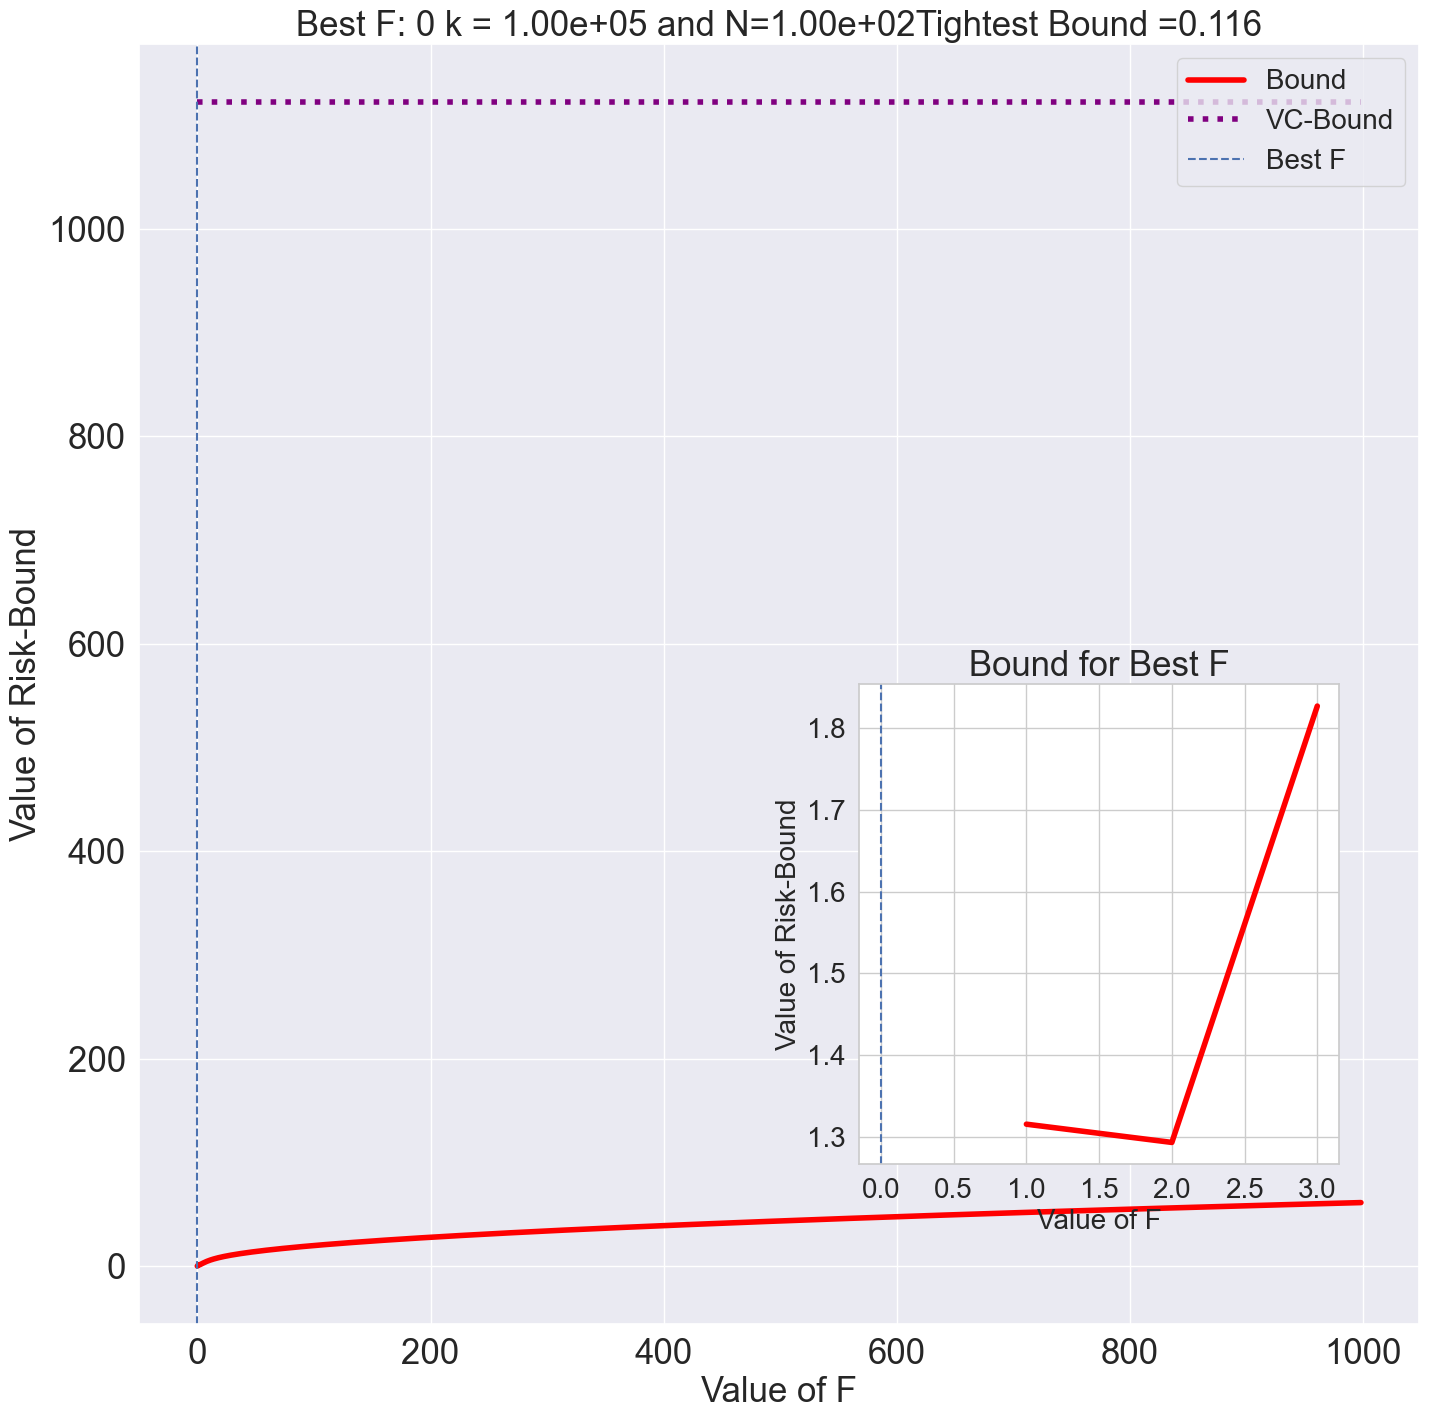

In [13]:
## Get Main Plot
bound_terms = []
for F_loop in F_in:
    bound_terms.append(get_risk_bound__scalar(F=F_loop,k=k,N=N))
# Get VC and Hoeffding-type Benchmark in plotting form
VC_benchmark = np.repeat(trivial_VCBound(),np.array(bound_terms).shape[0])
Hoeffding_benchmark = np.repeat(Hoeffding_Bound(),np.array(bound_terms).shape[0])
## Verbosity:
print('VC/Occam Bound is:'+str(trivial_VCBound()))
print('Hoeffding-Type Bound is:'+str(Hoeffding_Bound()))
    
ax = plt.figure(figsize=(16,16))
sns.set_style("darkgrid")


axes1 = ax.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes


# axes1.plot(wavelet_terms,color='orange', label = 'Local Embedding Cost',linewidth=4)
# axes1.plot(embedding_terms,color='blue',label = 'Global Embedding Quantity',linewidth=4)
axes1.plot(bound_terms,color='red', label = 'Bound',linewidth=4)
# axes1.plot(Hoeffding_benchmark,color='pink', label = 'Hoeffding-Bound',linewidth=4)
axes1.plot(VC_benchmark,color='purple', label = 'VC-Bound',linewidth=4,linestyle='dotted')
axes1.axvline(x=(BEST_F-1),label='Best F',linestyle="dashed")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


# Labels

plt.title('Best F: '+str(BEST_F-1)+' k = '+str('{:.2e}'.format(k))+' and N='+str('{:.2e}'.format(N)+'Tightest Bound ='+str(round(Tightest_Bound,3))),fontsize=25)
plt.xlabel("Value of F",fontsize=25)
plt.ylabel("Value of Risk-Bound",fontsize=25)
plt.legend(fontsize=20,loc='upper right')

# Get Zoomed Portion
## Near Best F
zoom_indices = np.array(range(max(1,BEST_F-2),min(BEST_F+3,F_in.shape[0])))
bound_terms__zoomed = np.array(bound_terms)[zoom_indices]
# VC_benchmark__zoomed
# Hoeffding_benchmark__zoomed

sns.set_style("whitegrid")
axes2 = ax.add_axes([0.55, 0.20, 0.3, 0.3]) # inset axes
axes2.set_title('Bound for Best F',fontsize=25)
# axes2.plot(zoom_indices,wavelet_terms__zoomed,color='orange', label = 'Local Embedding Cost',linewidth=4)
# axes2.plot(zoom_indices,embedding_terms__zoomed,color='blue',label = 'Global Embedding Quantity',linewidth=4)
axes2.plot(zoom_indices,bound_terms__zoomed,color='red', label = 'Bound',linewidth=4)
# axes2.plot(zoom_indices,VC_benchmark__zoomed,color='purple', label = 'VC-Bound',linewidth=4)
# axes2.plot(zoom_indices,Hoeffding_benchmark__zoomed,color='pink', label = 'Hoeffding-Bound',linewidth=4)
axes2.axvline(x=(BEST_F-1),linestyle="dashed")
plt.xlabel("Value of F",fontsize=20)
plt.ylabel("Value of Risk-Bound",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## First time VC-Looses
### Identify first time the VC bound looses
Trivial_VC_looses = Hoeffding_benchmark>=bound_terms
Trivial_VC_looses = np.argmax(Trivial_VC_looses>0)
print('The VC and Hoeffding Bounds Loose above F='+str(Trivial_VC_looses))
indices_VC = np.array(range(Trivial_VC_looses,VC_benchmark.shape[0]))

### Generate Plot
# wavelet_terms__zoomed___VCComparison = np.array(wavelet_terms)[indices_VC]
# embedding_terms__zoomed___VCComparison = np.array(embedding_terms)[indices_VC]
bound_terms__zoomed___VCComparison = np.array(bound_terms)[indices_VC]
VC_benchmark_plot = VC_benchmark[indices_VC]
# Hoeffding_benchmark__zoomed___VCComparison = Hoeffding_benchmark[indices_VC]

# Hoeffding Comparison
# sns.set_style("ticks")
# axes2 = ax.add_axes([0.25, 0.55, 0.3, 0.3]) # inset axes
# axes2.set_title(r'Beats Hoeffding Bound for F$\geq$'+str(Trivial_VC_looses),fontsize=25)
# axes2.plot(indices_VC,bound_terms__zoomed___VCComparison,color='red', label = 'Bound',linewidth=4)
# # axes2.plot(indices_VC,VC_benchmark_plot,color='purple', label = 'VC-Bound',linewidth=4)
# axes2.plot(indices_VC,Hoeffding_benchmark__zoomed___VCComparison,color='pink', label = 'Hoeffding-Bound',linewidth=4)
# axes2.axvline(x=(BEST_F-1),linestyle="dashed")
# plt.xlabel("Value of F",fontsize=20)
# plt.ylabel("Value of Risk-Bound",fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)


# Save and Show
# if Tightest_Bound <= 1:
#     ## Save PDF
#     plt.savefig('Experiments/PDF/NonVac_BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.pdf')
#     ## Save JPEG
#     plt.savefig('Experiments/JPG/NonVac_BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.jpg')
# else:
#     ## Save PDF
#     plt.savefig('Experiments/PDF/BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.pdf')
#     ## Save JPEG
#     plt.savefig('Experiments/JPG/BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.jpg')
## PLOT
plt.show()

## Best Bound As a Function of $Ratio=\frac{k}{N}$

In [18]:
# What Ratio to Use?
# Power or Multiplicative?
Use_Power_Ratio = True

In [19]:
def GET_BEST_F(kN_ratio,power_ratio = Use_Power_Ratio):
    
    # Set number of points in X x Y
    if power_ratio == True:
        k = int(math.ceil(N**kN_ratio)) # power ratio
    else:
        k = int(math.ceil(N*kN_ratio)) # multiplicative ratio

    BEST_F,min_bound = find_best(F_in,k)
    # print(BEST_F)
    
    return BEST_F,min_bound

### Compute Best Ratios

In [22]:
# Compute Best F as a function of ratio
# Ratios = np.linspace(0.001,10,10**4) # multiple-ratio
Ratios = np.linspace(0.00001,4,10**4) # power-ratio
best_F_ratio = GET_BEST_F(Ratios[0])[0] 
Optimal_F = [GET_BEST_F(ratio)[0] for ratio in Ratios]

x_ratios = []
y_optimals = []
idx = 0
for i in Optimal_F:
    if i not in y_optimals:
        y_optimals.append(i)
        x_ratios.append(idx)
    idx += 1

### Plot Results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: 'Experiments/Ratio_Plot/PDF/Power_ratio_N100.pdf'

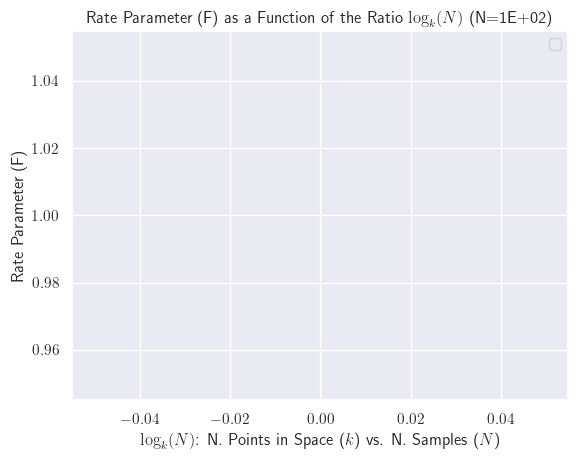

In [28]:
plt.plot(x_ratios,y_optimals,color='purple')
plt.rcParams['text.usetex'] = True


# Labels
if Use_Power_Ratio == False:
    plt.title('Rate Parameter (F) as a Function of Ratio (k/N) (N='+str(format_e(Decimal(N)))+')')
    plt.xlabel("Ratio: N. Points in Space/N. Samples (k/N)")
else:
    plt.title(r'Rate Parameter (F) as a Function of the Ratio $\log_k(N)$ (N='+str(format_e(Decimal(N)))+')')
    plt.xlabel(r'$\log_k(N)$: N. Points in Space ($k$) vs. N. Samples ($N$)')
    
plt.ylabel("Rate Parameter (F)")
plt.legend()

## Save and Show
if Use_Power_Ratio == False:
    # ## Save PDF
    plt.savefig('Experiments/Ratio_Plot/PDF/N'+str(N)+'.pdf')
    ## Save JPEG
    plt.savefig('Experiments/Ratio_Plot/JPG/N'+str(N)+'.jpg')
else:
    # ## Save PDF
    plt.savefig('Experiments/Ratio_Plot/PDF/Power_ratio_N'+str(N)+'.pdf')
    ## Save JPEG
    plt.savefig('Experiments/Ratio_Plot/JPG/Power_ratio_'+str(N)+'.jpg')
    
# ## PLOT
plt.show()

---
# Fin #
---